In [1]:
# Librerias base
# Probablemente para análisis estadísticos más complejos necesitariamos
# emplear librerias especializadas como scipy o statsmodels.
# Por ahora solo vamos a usar las básicas.

import os
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.lines as mlines
import networkx as nx
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


# Crear carpetas para almacenar los datos
#data_scimago = pd.read_csv("scimago.csv", sep=",")
folders = ["figura_tres", "figura_cuatro", "figura_dos", "figura_uno"]
for folder in folders:
    os.makedirs(folder, exist_ok=True)
    print(f"Carpeta creada: {folder}")

Carpeta creada: figura_tres
Carpeta creada: figura_cuatro
Carpeta creada: figura_dos
Carpeta creada: figura_uno


In [4]:
# Cargar datos desde el Excel
file_path = "all_data_stem_1.xlsx"

# Leer las hojas del Excel
wos_scopus = pd.read_excel(file_path, sheet_name=0)
wos = pd.read_excel(file_path, sheet_name=1)
scopus = pd.read_excel(file_path, sheet_name=2)
reference_df = pd.read_excel(file_path, sheet_name=3)
journal_df = pd.read_excel(file_path, sheet_name=4)
author_df = pd.read_excel(file_path, sheet_name=5)
TC_all = pd.read_excel(file_path, sheet_name=6)
figure_1_data = pd.read_excel(file_path, sheet_name=7)
table_2_country = pd.read_excel(file_path, sheet_name=9)
figure_2_country_wos_scopus = pd.read_excel(file_path, sheet_name=10)
table_3_journal = pd.read_excel(file_path, sheet_name=12)
table_4_authors = pd.read_excel(file_path, sheet_name=13)
tos = pd.read_excel(file_path, sheet_name=15)
edges_tos = pd.read_excel(file_path, sheet_name=16)
nodes_tos = pd.read_excel(file_path, sheet_name=17)
SO_edges = pd.read_excel(file_path, sheet_name=18)
SO_nodes = pd.read_excel(file_path, sheet_name=19)
AU_ego_edges = pd.read_excel(file_path, sheet_name=20)
AU_ego_nodes = pd.read_excel(file_path, sheet_name=21)

print("Datos cargados correctamente.")

Datos cargados correctamente.


In [5]:
figure_2_country_wos_scopus_1 = nx.from_pandas_edgelist(pd.read_excel(file_path, sheet_name=11), source="from", target="to", edge_attr="Weight")

# Calcular el grado de cada nodo
degree_dict = dict(figure_2_country_wos_scopus_1.degree())

# Detección de comunidades usando Louvain
communities = community_louvain.best_partition(figure_2_country_wos_scopus_1, random_state=0)

# Contar la cantidad de nodos en cada comunidad
community_sizes = pd.Series(communities).value_counts()

# Ordenar de mayor a menor y asignar nuevos índices (0 para la más grande, 1 para la segunda, etc.)
sorted_communities = community_sizes.index.tolist()
community_mapping = {old_comm: new_index+1 for new_index, old_comm in enumerate(sorted_communities)}

# Reasignar las comunidades en el grafo
updated_communities = {node: community_mapping[comm] for node, comm in communities.items()}

# Agregar atributos al grafo
nx.set_node_attributes(figure_2_country_wos_scopus_1, degree_dict, "degree")
nx.set_node_attributes(figure_2_country_wos_scopus_1, updated_communities, "community")

In [6]:
# Guardar en CSV los datos necesarios
figure_1_data.to_csv("figura_dos/figura2.csv", index=False)
SO_edges.to_csv("figura_tres/SO_edges.csv", index=False)
SO_nodes.to_csv("figura_tres/SO_nodes.csv", index=False)
AU_ego_edges.to_csv("figura_cuatro/AU_edges.csv", index=False)
AU_ego_nodes.to_csv("figura_cuatro/AU_nodes.csv", index=False)

print("Archivos CSV guardados correctamente.")

Archivos CSV guardados correctamente.


In [7]:
# Crear tabla con el conteo de artículos
table_1 = pd.DataFrame({
    "WoS": [len(wos)],
    "Scopus": [len(scopus)],
    "Total": [len(wos_scopus)]
})

# Mostrar tabla
import IPython.display as display
display.display(table_1)

,WoS,Scopus,Total
0,958,794,1618


In [8]:
# Expandir los valores de la columna DT (separados por ";")
# Aquí hubieron varios problemas que creo que se pueden trabajar desde el pre
# Básicamente estamos teniendo problemas con caracteres, por lo que se considera
# necesario limpiar los datos. O utilizar la importación con formato UTF-8.

wos_scopus_expanded = wos_scopus.assign(DT=wos_scopus["DT"].str.split(";")).explode("DT")

# Contar la cantidad de artículos por tipo
document_counts = wos_scopus_expanded["DT"].value_counts().reset_index()
document_counts.columns = ["Article Type", "Total"]

# Calcular porcentaje
document_counts["Percentage"] = round((document_counts["Total"] / document_counts["Total"].sum()) * 100, 2)

# Mostrar tabla
display.display(document_counts)

,Article Type,Total,Percentage
0,ARTICLE,941,56.79
1,CONFERENCE PAPER,408,24.62
2,REVIEW,144,8.69
3,BOOK CHAPTER,57,3.44
4,EARLY ACCESS,27,1.63
5,CONFERENCE REVIEW,26,1.57
6,EDITORIAL MATERIAL,12,0.72
7,NOTE,8,0.48
8,BOOK,8,0.48
9,PROCEEDINGS PAPER,8,0.48


# F1


In [9]:
# Definir el rango de años
# Toca revisar el Rpubs para este proceso xd
year_start = 1990
year_end = 2024
years_full = np.arange(year_start, year_end + 1)

# Completar datos faltantes en figure_1_data
for year in years_full:
    if year not in figure_1_data["PY"].values:
        total_wos = len(wos[wos["PY"] == year])
        total_scopus = len(scopus[scopus["PY"] == year])
        total_wos_scopus = len(wos_scopus[wos_scopus["PY"] == year])
        new_row = pd.DataFrame({"PY": [year], "total": [total_wos_scopus], "scopus": [total_scopus], "wos": [total_wos]})
        figure_1_data = pd.concat([figure_1_data, new_row], ignore_index=True)

# Ordenar datos por año
figure_1_data = figure_1_data.sort_values("PY", ascending=False)

# Calcular citas totales por año
# De aquí para abajo, los pasos se pueden simplificar hacer en el preprocesamiento para ahorrar tiempo.
TC_all = pd.DataFrame(columns=["PY", "TC_sum_all", "TC_percentage"])

for year in years_full:
    ncitas_wos = wos[wos["PY"] == year]["TC"].sum()
    ncitas_scopus = scopus[scopus["PY"] == year]["TC"].sum()
    ncitas = ncitas_wos + ncitas_scopus
    new_row_tc = pd.DataFrame({"PY": [year], "TC_sum_all": [ncitas], "TC_percentage": [None]})
    TC_all = pd.concat([TC_all, new_row_tc], ignore_index=True)

# Calcular porcentaje de citas
total_citas = TC_all["TC_sum_all"].sum()
TC_all["TC_percentage"] = round((TC_all["TC_sum_all"] / total_citas) * 100, 2)

# Asegurar formato de enteros
TC_all["TC_sum_all"] = TC_all["TC_sum_all"].astype(int)

# Ordenar por año
TC_all = TC_all.sort_values("PY", ascending=False)

print("Preprocesamiento completado.")

Preprocesamiento completado.


In [10]:
# Extraer valores para la gráfica
tcx = TC_all["PY"].values
tcy = TC_all["TC_sum_all"].astype(int).values

tpx = figure_1_data["PY"].values
tpy = figure_1_data["total"].astype(int).values

wx = figure_1_data["PY"].values
wx1 = wx - 0.3  # Desplazamiento de barras WoS
wy = figure_1_data["wos"].astype(int).values

sx = figure_1_data["PY"].values
sx1 = sx + 0.5  # Desplazamiento de barras Scopus
sy = figure_1_data["scopus"].astype(int).values

print("Datos listos para la visualización.")


Datos listos para la visualización.


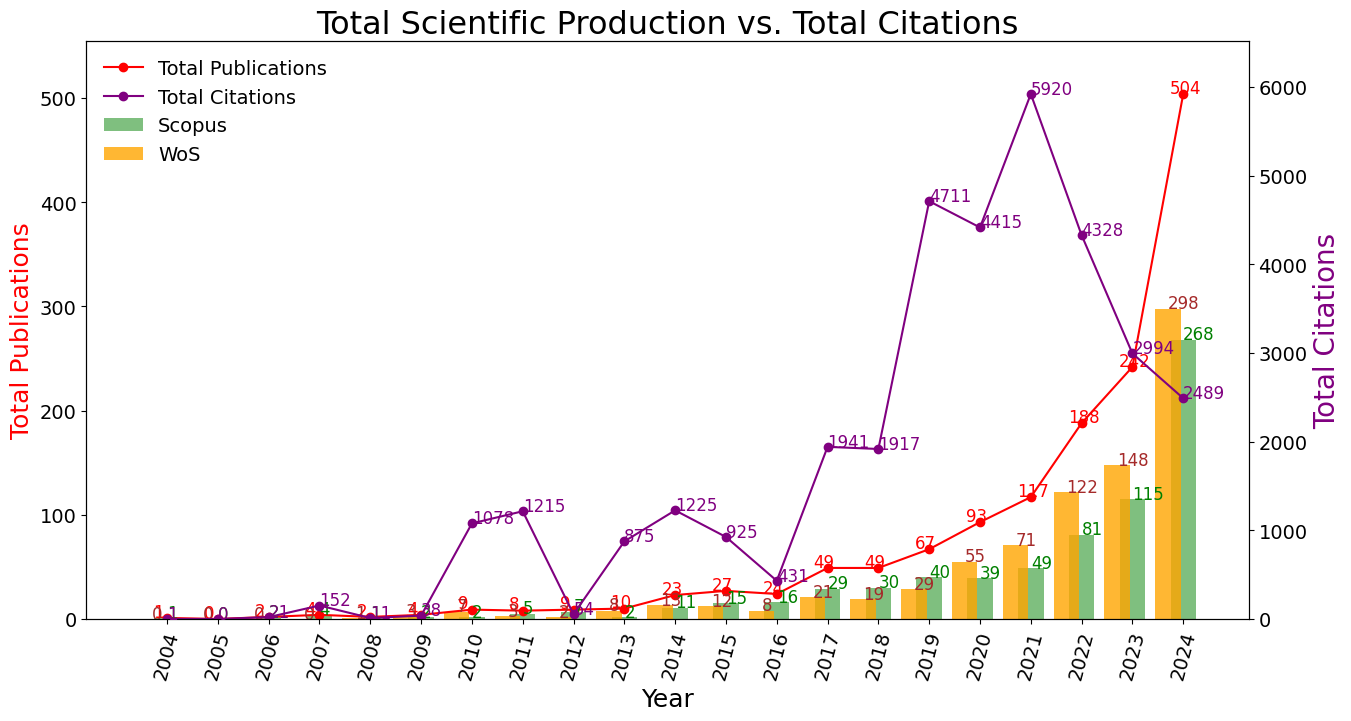

In [11]:
legend_elements = [
    Line2D([0], [0], color='red', marker='o', label='Total Publications'),
    Line2D([0], [0], color='purple', marker='o', label='Total Citations'),
    Patch(facecolor='green', alpha=0.5, label='Scopus'),
    Patch(facecolor='orange', alpha=0.8, label='WoS')
]

# Filtrar los datos para incluir solo años
start_year = 2004
mask_years = tpx >= start_year

# Aplicar la máscara a todas las variables correspondientes
tpx, tpy = tpx[mask_years], tpy[mask_years]
tcx, tcy = tcx[mask_years], tcy[mask_years]
wx1, wy = wx1[mask_years], wy[mask_years]
sx, sy = sx[mask_years], sy[mask_years]

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(15, 7.5))

# Línea roja para total de publicaciones
ax.plot(tpx, tpy, color='r', marker='o', label='Total Publications')

# Etiquetas de ejes
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Total Publications', color='r', fontsize=18)

# Barras de WoS y Scopus
barw = 0.5
ax.bar(sx, sy, color='g', label='Scopus', alpha=0.5, width=barw)
ax.bar(wx1, wy, color='orange', label='WoS', alpha=0.8, width=barw)

# Segundo eje para citas totales
twin_axes = ax.twinx()
twin_axes.plot(tcx, tcy, color='purple', marker='o', label='Total Citations')
twin_axes.set_ylabel('Total Citations', color='purple', fontsize=20)
ax.set_ylim(0, max(tpy) * 1.1)
twin_axes.set_ylim(0, max(tcy) * 1.1)

# Título y leyendas
plt.title('Total Scientific Production vs. Total Citations', fontsize=23)
plt.legend(handles=legend_elements, loc='upper left', fontsize=14, frameon=False)

# Ajustar etiquetas del eje X
ax.set_xticks(tpx)
ax.set_xticklabels(tpx.astype(int), fontsize=14, rotation=75)

# Aumentar tamaño de los valores en todos los ejes
ax.tick_params(axis='x', labelsize=14)         # Eje X
ax.tick_params(axis='y', labelsize=14)         # Eje Y izquierdo
twin_axes.tick_params(axis='y', labelsize=14)  # Eje Y derecho

# Título y leyendas con tamaño de fuente aumentado
plt.title('Total Scientific Production vs. Total Citations', fontsize=23)


# Etiquetas en las barras y puntos
for i, label in enumerate(tcy):
    twin_axes.annotate(label, (tcx[i], tcy[i] + 0.5), color='purple', size=12)
for i, label in enumerate(tpy):
    ax.annotate(label, (tpx[i], tpy[i] + 1), xytext=(-10, 0), textcoords='offset points', color='red', size=12)
for i, label in enumerate(wy):
    ax.annotate(label, (wx1[i], wy[i] + 0.1), color='brown', size=12)
for i, label in enumerate(sy):
    ax.annotate(label, (sx[i], sy[i] + 0.2), color='green', size=12)

# Guardar figura
plt.savefig("./figura_uno/figura_1.svg")
plt.savefig("./figura_uno/figura_1.png", dpi=300)
plt.show()




## Country Analysis

In [12]:
df = table_2_country
filtered_df = df[df["AU_CO"] == "USA"]
df

,AU_CO,count_co,percentage_co,citation,percentage_ci,Q1,Q2,Q3,Q4,no_category
0,USA,577,23.08,18307,5.80,243,48,18,8,260
1,CHINA,355,14.20,10625,3.37,212,34,12,12,85
2,JAPAN,90,3.60,7899,2.50,62,9,5,0,14
3,GERMANY,88,3.52,9427,2.99,50,6,2,3,27
4,INDIA,82,3.28,5314,1.68,28,8,5,6,35
5,UNITED KINGDOM,77,3.08,8825,2.80,51,4,3,3,16
6,ITALY,67,2.68,7255,2.30,33,5,1,3,25
7,SPAIN,60,2.40,7477,2.37,32,1,3,3,21
8,AUSTRALIA,57,2.28,6120,1.94,34,4,1,0,18
9,MALAYSIA,52,2.08,3286,1.04,23,9,4,2,14


In [ ]:
pip install python-docx

In [13]:
df = table_2_country

from docx import Document
from docx.shared import Pt
from docx.enum.table import WD_TABLE_ALIGNMENT, WD_ALIGN_VERTICAL
import pandas as pd

# --- Cargar y preparar los datos ---
df_table_1 = df
df_table_1 = df.drop(columns=["no_category"])
df_table_1.columns = [
    "Country", "Production Count", "Production %",
    "Citation Count", "Citation %", "Q1", "Q2", "Q3", "Q4"
]

# --- Crear documento Word ---
doc = Document()
doc.add_heading("Table 2. Scientific Production and Impact by Country", level=2)

# --- Crear tabla con doble fila de encabezados ---
table = doc.add_table(rows=2, cols=9)
table.alignment = WD_TABLE_ALIGNMENT.CENTER
table.style = "Table Grid"

# --- Fila 1 (títulos agrupados) ---
hdr_1 = table.rows[0].cells
hdr_1[0].text = "Country"
hdr_1[1].merge(hdr_1[2]).text = "Production"
hdr_1[3].merge(hdr_1[4]).text = "Citation"
hdr_1[5].merge(hdr_1[8]).text = "Quality"

# --- Fila 2 (subtítulos por columna) ---
hdr_2 = table.rows[1].cells
hdr_2[0].text = ""
hdr_2[1].text = "Count"
hdr_2[2].text = "%"
hdr_2[3].text = "Count"
hdr_2[4].text = "%"
hdr_2[5].text = "Q1"
hdr_2[6].text = "Q2"
hdr_2[7].text = "Q3"
hdr_2[8].text = "Q4"

# --- Estilizar encabezados (centrado y negrita segura) ---
for row in table.rows[:2]:
    for cell in row.cells:
        for paragraph in cell.paragraphs:
            paragraph.alignment = 1  # Centrado
            if paragraph.runs:
                run = paragraph.runs[0]
                run.bold = True
                run.font.size = Pt(10)

# --- Agregar filas de datos ---
for row_data in df_table_1.itertuples(index=False, name=None):
    row_cells = table.add_row().cells
    for i, value in enumerate(row_data):
        row_cells[i].text = str(value)
        row_cells[i].vertical_alignment = WD_ALIGN_VERTICAL.CENTER
        row_cells[i].paragraphs[0].alignment = 1  # Centrado

# --- Fuente al final ---
doc.add_paragraph("Source: Self-prepared.", style='Normal')

# --- Guardar documento ---
doc.save("tabla_impacto_paises_estilizada.docx")

Figure 2a - Country Collaboration

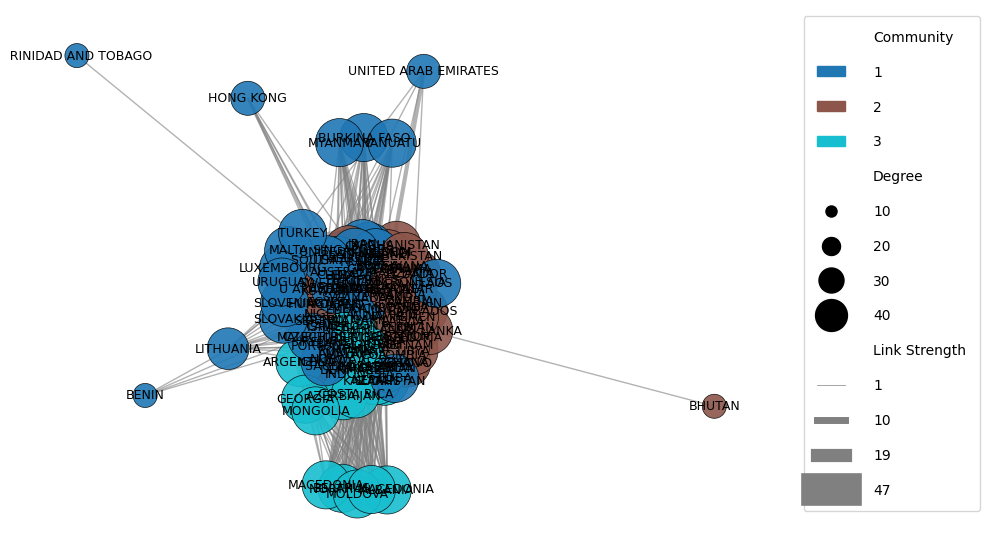

In [14]:
from matplotlib.legend_handler import HandlerTuple
G = figure_2_country_wos_scopus_1


# 2. Calcular la posición de cada nodo (layout)
pos = nx.spring_layout(G)

# 3. Obtener la comunidad y el grado de cada nodo
#    (Asegúrate de que cada nodo tenga el atributo "community" en el GEXF)
node_communities = nx.get_node_attributes(G, "community")
node_degrees = degree_dict  # Si quieres usar grados ponderados usa: G.degree(weight="weight")

# 5. Asignar color y tamaño a cada nodo
#    (Puedes usar un escalado continuo o discreto para el tamaño, según tus preferencias)
def map_degree_to_size(d):
    """Mapea grados a tamaños de nodo. Ajusta los umbrales y valores a tus datos."""
    if d < 5:
        return 300
    elif d < 10:
        return 600
    elif d < 15:
        return 900
    else:
        return 1200


# 6. Obtener el grosor de cada arista a partir de su atributo "weight" (fuerza de enlace)
#    (asumiendo que en tu GEXF el atributo se llame "weight")
node_sizes = []

for n in G.nodes():
    d_value = node_degrees.get(n, 0)
    node_sizes.append(map_degree_to_size(d_value))


edge_widths = []
for (u,v) in G.edges():
    w = G[u][v].get("Weight")
    edge_widths.append(w)

# for u, v, data in G.edges(data=True):
#      data["weight"] = data.pop("Weight")  # Elimina "Weight" y lo reasigna como "weight"

communities_set = sorted(set(nx.get_node_attributes(G, 'community').values()))
color_map = plt.get_cmap('tab10', len(communities_set))
node_colors = {n: color_map(communities_set.index(G.nodes[n]['community'])) for n in G.nodes}

for node, color in node_colors.items():
    r, g, b, a = [int(color[i] * 255) for i in range(3)] + [color[3]]  # a ya está en 0-1

    G.nodes[node]['viz'] = {
        "color": {"r": r, "g": g, "b": b, "a": a}  # a ya está en el rango correcto
    }

node_colors = [color_map(communities_set.index(G.nodes[n]['community'])) for n in G.nodes]


# 7. Dibujar los nodos, aristas y etiquetas
plt.figure(figsize=(10, 6))

# Dibujar nodos, aristas y etiquetas
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.9,
    linewidths=0.5,
    edgecolors="black"
)
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.6,
    edge_color="gray"
)
nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    font_color="black",
)

# Crear leyenda de comunidades
# Leyenda de comunidades (solo número)
community_legend = [
    Patch(color=color_map(communities_set.index(c)), label=f"{c}")
    for c in communities_set
]

# Leyenda de grados (solo intervalo)
degree_legend = [
    Line2D([0], [0], marker='o', color='w', label='10',
           markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='20',
           markerfacecolor='black', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='30',
           markerfacecolor='black', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='40',
           markerfacecolor='black', markersize=25)
]

unique_weights = sorted(set(int(w) for _,_,w in G.edges(data="Weight") if w is not None))

if len(unique_weights) >= 4:
    selected_weights = [
        unique_weights[0],
        unique_weights[len(unique_weights)//3],
        unique_weights[2*len(unique_weights)//3],
        unique_weights[-1]
    ]
else:
    selected_weights = unique_weights

def map_weight_to_width(w):
    return w * 0.5

# 4. Crear la leyenda con pesos reales
linkstrength_legend = [
    Line2D([0], [0], color='gray', lw=map_weight_to_width(w), label=f"{int(w)}")
    for w in selected_weights
]

title_community = Line2D([], [], color='none', label="Community")
title_degree = Line2D([], [], color='none', label="Degree")
title_linkstrength = Line2D([], [], color='none', label="Link Strength")


community_legend = [title_community] + community_legend
degree_legend = [title_degree] + degree_legend
linkstrength_legend = [title_linkstrength] + linkstrength_legend

# Mostrar la leyenda con títulos
plt.legend(
    handles=(community_legend + degree_legend + linkstrength_legend),
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    labelspacing=1.5,      # Espacio vertical entre líneas
    handletextpad=2,       # Espacio entre el marcador y el texto
    borderpad=1            # Espacio del borde de la leyenda con su contenido
)


plt.axis("off")
plt.tight_layout()
plt.savefig("./figura_dos/figura_2c.svg", format='svg')

gexf_path = "figura_dos/paises_collaboration_graph_louvain.gexf"
nx.write_gexf(G, gexf_path)
plt.show()

Figure 2b Clusters


   community   n  x_axis
2          3  26       0
1          2  48       1
0          1  49       2


<Figure size 640x480 with 0 Axes>

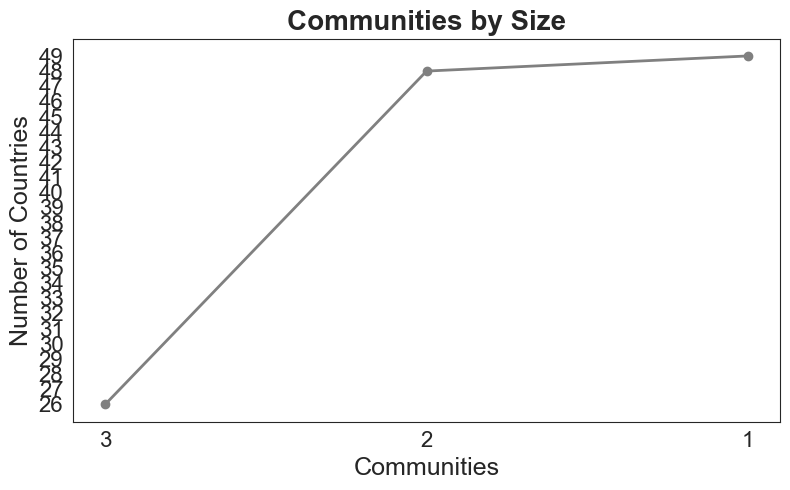

In [17]:
# Crear DataFrame con la nueva numeración de comunidades
nodes_df = pd.DataFrame.from_dict(dict(figure_2_country_wos_scopus_1.nodes(data=True)), orient='index')
nodes_df['node'] = nodes_df.index
nodes_df.reset_index(drop=True, inplace=True)
nodes_df['community'] = nodes_df['community'].astype(int)

# Contar comunidades con la numeración corregida
community_counts = nodes_df['community'].value_counts().reset_index()
community_counts.columns = ['community', 'n']
community_counts = community_counts.sort_values('community', ascending=False,)


# Configurar estilo de plot
community_counts['x_axis'] = range(len(community_counts))

sns.set_style("white")
sns.despine()  # Elimina bordes superiores y derechos

plt.figure(figsize=(8, 5))

# Gráfico de línea con puntos
plt.plot(
    community_counts['x_axis'],
    community_counts['n'],
    marker='o',
    linestyle='-',
    color='gray',
    linewidth=2,
    markersize=6
)

# Títulos y etiquetas
plt.title("Communities by Size", fontsize=20, weight='bold')
plt.xlabel("Communities", fontsize=18)
plt.ylabel("Number of Countries", fontsize=18)

# Etiquetas del eje x
plt.xticks(community_counts['x_axis'], community_counts['community'], fontsize=16)

# Evitar decimales en el eje Y
max_y = community_counts['n'].max()
min_y = community_counts['n'].min()
plt.yticks(range(min_y, max_y + 1), fontsize=16)


# Layout y guardado
plt.tight_layout()

# Guardar como SVG (opcional)
plt.savefig('./figura_dos/figura_2b.svg', format='svg')

# Mostrar la tabla de comunidades para referencia
print(community_counts)

plt.show()

## Figure 2c Longitudinal

In [18]:
yearStart = start_year
yearEnd = year_end

figure_2c_edges = (
    figure_2_country_wos_scopus[figure_2_country_wos_scopus['from'] != figure_2_country_wos_scopus['to']]
    .groupby('PY')
    .size()
    .reset_index(name='n')
    .query('PY >= @yearStart and PY <= @yearEnd')
    .assign(percentage=lambda x: x['n'] / x['n'].max())
    [['PY', 'percentage']]
    .rename(columns={'PY': 'year'})
)
df_valid = figure_2_country_wos_scopus[figure_2_country_wos_scopus['from'] != figure_2_country_wos_scopus['to']].reset_index(drop=True)


unique_countries = pd.concat([
    figure_2_country_wos_scopus['from'],
    figure_2_country_wos_scopus['to']
]).unique()

country_to_id = {country: idx for idx, country in enumerate(sorted(unique_countries), start=1)}


def create_nodes_dataframe():
    # Filtrar donde from != to
    filtered_df = figure_2_country_wos_scopus[figure_2_country_wos_scopus['from'] != figure_2_country_wos_scopus['to']]
    # Crear un grafo dirigido
    G = nx.from_pandas_edgelist(filtered_df, 'from', 'to', create_using=nx.DiGraph())
    # Obtener datos de aristas
    edges_from = filtered_df[['from', 'PY']].rename(columns={'from': 'CO', 'PY': 'year'})
    # Obtener datos de aristas (destino)
    edges_to = figure_2_country_wos_scopus[['to', 'PY']].rename(columns={'to': 'CO', 'PY': 'year'})
    # Combinar ambos conjuntos de datos
    combined_edges = pd.concat([edges_from, edges_to])
    # Eliminar duplicados
    unique_edges = combined_edges.drop_duplicates()
    # Agrupar por país y obtener el año mínimo para cada país
    min_year_by_country = unique_edges.groupby('CO')['year'].min().reset_index()
    # Seleccionar solo la columna de año
    years_df = min_year_by_country[['year']]
    # Contar por año
    count_by_year = years_df.groupby('year').size().reset_index(name='n')
    # Filtrar por rango de años
    filtered_by_year = count_by_year[(count_by_year['year'] >= yearStart) &
                                 (count_by_year['year'] <= yearEnd)].copy()
    # Calcular porcentaje
    filtered_by_year['percentage'] = filtered_by_year['n'] / filtered_by_year['n'].max()
    # Seleccionar columnas finales
    figure_2c_nodes = filtered_by_year[['year', 'n', 'percentage']]
    return figure_2c_nodes


figure_2c_nodes = create_nodes_dataframe()



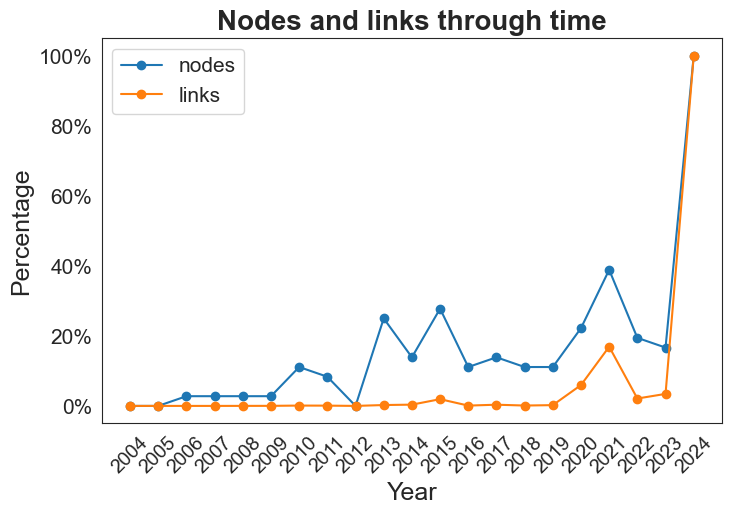

In [19]:
# Combine nodes and edges DataFrames
figure_2c = pd.concat([
    figure_2c_nodes.assign(type='nodes', year=figure_2c_nodes['year'].astype(int)),
    figure_2c_edges.assign(type='links', year=figure_2c_edges['year'].astype(int))
])

# Create the plot
plt.figure(figsize=(8, 5))

years = pd.Series(range(yearStart, yearEnd + 1), name='year')
complete_data = []

for type_name in ['nodes', 'links']:
    # Filtrar los datos de ese tipo
    data = figure_2c[figure_2c['type'] == type_name][['year', 'percentage']]
    
    # Merge con todos los años
    merged = pd.merge(years, data, on='year', how='left')
    merged['percentage'] = merged['percentage'].fillna(0)
    merged['type'] = type_name
    
    complete_data.append(merged)

# Combinar los datos completos
figure_2c_filled = pd.concat(complete_data)


# Plot nodes and links
for type_name in ['nodes', 'links']:
    data = figure_2c_filled[figure_2c_filled['type'] == type_name]
    plt.plot(data['year'], data['percentage'],
             marker='o',
             label=type_name,
             linestyle='-')

# Customize the plot
plt.title("Nodes and links through time", fontsize=20, weight='bold')
plt.ylabel("Percentage", fontsize=18)
plt.xlabel("Year", fontsize=18)

# Set y-axis to percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.yticks(fontsize=15)

# Customize x-axis
plt.xticks(range(yearStart, yearEnd + 1), rotation=45, fontsize=14)

# Customize appearance
plt.gca().set_facecolor('white')

# Add legend
plt.legend(title=None, fontsize=15, loc="upper left")

# Adjust layout and add grid
#plt.grid(True, linestyle="--", alpha=0.5)

# Save the plot
plt.savefig("./figura_dos/figura_2a.svg", format='svg')

# Optional: display the plot (comment out if not in interactive environment)
plt.show()

## 3.3 Journal
### Table 3 Most productive journals

In [20]:
# 1. Ordenar y seleccionar los primeros 10
journals_sorted = table_3_journal.sort_values('total', ascending=False).head(10).copy()

# 2. Poner en mayúscula los nombres de las revistas
journals_sorted['journal'] = journals_sorted['journal'].str.upper()

# 3. Crear el nuevo DataFrame con las columnas deseadas
df_journals = journals_sorted[['journal', 'wos', 'scopus', 'total']]

# 4. Poner las columnas en Title Case
df_journals.columns = df_journals.columns.str.title()

df_journals


,Journal,Wos,Scopus,Total
49,"ASEE ANNUAL CONFERENCE AND EXPOSITION, CONFERE...",0,72,72
267,INTERNATIONAL JOURNAL OF ARTIFICIAL INTELLIGEN...,53,9,54
394,LECTURE NOTES IN COMPUTER SCIENCE (INCLUDING S...,0,33,33
472,PROCEEDINGS - FRONTIERS IN EDUCATION CONFERENC...,0,30,30
106,COMMUNICATIONS IN COMPUTER AND INFORMATION SCI...,0,25,25
214,IEEE ACCESS,20,4,21
139,EDUCATION AND INFORMATION TECHNOLOGIES,17,9,17
179,FRONTIERS IN EDUCATION,16,10,16
1,ACM INTERNATIONAL CONFERENCE PROCEEDING SERIES,0,16,16
395,LECTURE NOTES IN NETWORKS AND SYSTEMS,0,14,14


In [21]:
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.enum.table import WD_ALIGN_VERTICAL, WD_TABLE_ALIGNMENT


df_table_1 = df_journals

# --- Crear documento Word ---
doc = Document()
doc.add_heading("Table 2. Scientific Production and Impact by Country", level=2)

# --- Crear tabla con filas y columnas dinámicas ---
num_rows, num_cols = df_table_1.shape
table = doc.add_table(rows=num_rows + 1, cols=num_cols)  # +1 para encabezados
table.alignment = WD_TABLE_ALIGNMENT.CENTER
table.style = "Table Grid"

# --- Insertar encabezados automáticamente ---
hdr_cells = table.rows[0].cells
for i, column_name in enumerate(df_table_1.columns):
    hdr_cells[i].text = column_name
    hdr_cells[i].paragraphs[0].alignment = WD_PARAGRAPH_ALIGNMENT.CENTER
    hdr_cells[i].paragraphs[0].runs[0].bold = True
    hdr_cells[i].paragraphs[0].runs[0].font.size = Pt(11)

# --- Insertar datos automáticamente ---
for i, row in enumerate(df_table_1.itertuples(index=False, name=None), start=1):
    row_cells = table.rows[i].cells
    for j, value in enumerate(row):
        row_cells[j].text = str(value)
        row_cells[j].vertical_alignment = WD_ALIGN_VERTICAL.CENTER
        row_cells[j].paragraphs[0].alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

# --- Fuente al final ---
doc.add_paragraph("Source: Self-prepared.", style='Normal')

# --- Guardar documento ---
doc.save("tabla_journal.docx")

### Figure 3 Journal Citation Network

Creating the graph object

In [22]:
def create_journal_citation_graph(journal_df):
    # Create edge list with weights
    edge_weights = (journal_df[['JI_main', 'JI_ref']]
                    .groupby(['JI_main', 'JI_ref'])
                    .size()
                    .reset_index(name='weight'))

    # Create networkx graph
    G = nx.from_pandas_edgelist(edge_weights,
                                source='JI_main',
                                target='JI_ref',
                                edge_attr='weight',
                                create_using=nx.Graph())

    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))

    # Find weakly connected components and keep only the largest component
    components = list(nx.connected_components(G))
    largest_component = max(components, key=len)
    G = G.subgraph(largest_component).copy()

    # Calculate node degrees
    degrees = dict(G.degree())
    nx.set_node_attributes(G, degrees, 'degree')

    # Community detection using Louvain method
    communities = community_louvain.best_partition(G, random_state=42)

    # Contar el número de nodos en cada comunidad
    community_sizes = {}
    for node, comm in communities.items():
        community_sizes[comm] = community_sizes.get(comm, 0) + 1

    # Ordenar comunidades por tamaño (de mayor a menor)
    sorted_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)

    # Crear un mapeo de comunidad original a su nuevo índice según el tamaño
    community_mapping = {old_comm: new_index+1 for new_index, old_comm in enumerate(sorted_communities)}

    # Asignar los nuevos índices a las comunidades
    updated_communities = {node: community_mapping[comm] for node, comm in communities.items()}

    nx.set_node_attributes(G, updated_communities, 'community')

    # Filter nodes with degree >= 1
    G = G.subgraph([node for node, degree in degrees.items() if degree >= 1]).copy()

    return G

journal_citation_graph_weighted_tbl_small = create_journal_citation_graph(journal_df)



Selecting nodes to show

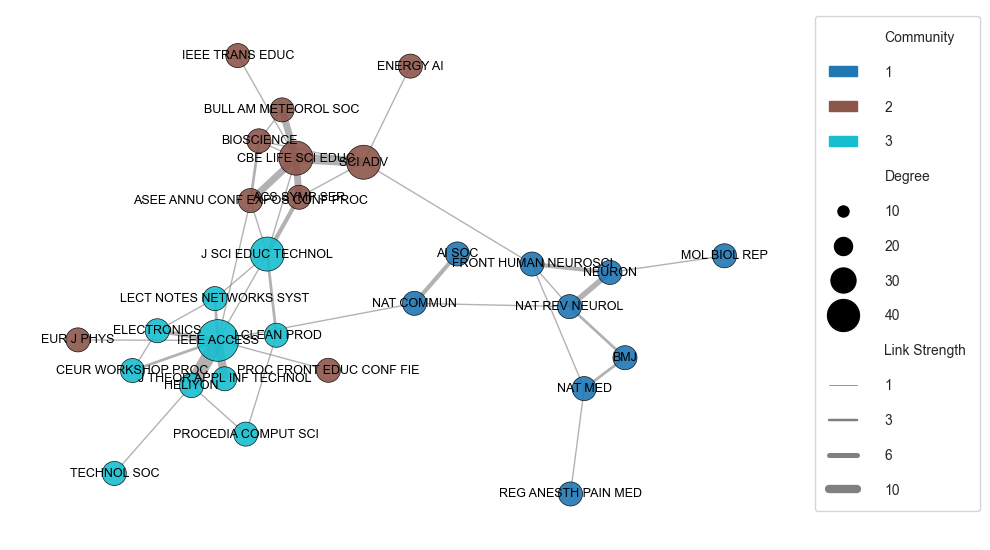

In [23]:

G = nx.from_pandas_edgelist(SO_edges, 'Source', 'Target', edge_attr='weight')
# Agregar atributos de nodos desde SO_nodes
node_attrs = SO_nodes.set_index('id').to_dict('index')
nx.set_node_attributes(G, node_attrs)

# Obtener comunidades y grados
communities = nx.get_node_attributes(G, 'community')
degree = dict(G.degree())

# 2. Calcular la posición de cada nodo (layout)
pos = nx.spring_layout(G, seed=42)

# 3. Obtener la comunidad y el grado de cada nodo
#    (Asegúrate de que cada nodo tenga el atributo "community" en el GEXF)
node_communities = nx.get_node_attributes(G, "community")
node_degrees = degree  # Si quieres usar grados ponderados usa: G.degree(weight="weight")


# 5. Asignar color y tamaño a cada nodo
#    (Puedes usar un escalado continuo o discreto para el tamaño, según tus preferencias)
def map_degree_to_size(d):
    """Mapea grados a tamaños de nodo. Ajusta los umbrales y valores a tus datos."""
    if d < 5:
        return 300
    elif d < 10:
        return 600
    elif d < 15:
        return 900
    else:
        return 1200

node_sizes = []

for n in G.nodes():
    d_value = node_degrees.get(n, 0)
    node_sizes.append(map_degree_to_size(d_value))

edge_widths = []
for (u,v) in G.edges():
    w = G[u][v].get("weight")
    edge_widths.append(w)

# for u, v, data in G.edges(data=True):
#     data["Weight"] = data.pop("weight")


communities_set = sorted(set(nx.get_node_attributes(G, 'community').values()))
color_map = plt.get_cmap('tab10', len(communities_set))
node_colors = {n: color_map(communities_set.index(G.nodes[n]['community'])) for n in G.nodes}

for node, color in node_colors.items():
    r, g, b, a = [int(color[i] * 255) for i in range(3)] + [color[3]]  # a ya está en 0-1

    G.nodes[node]['viz'] = {
        "color": {"r": r, "g": g, "b": b, "a": a}  # a ya está en el rango correcto
    }

node_colors = [color_map(communities_set.index(G.nodes[n]['community'])) for n in G.nodes]

# 7. Dibujar los nodos, aristas y etiquetas
plt.figure(figsize=(10, 6))

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.9,
    linewidths=0.5,
    edgecolors="black"
)
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.6,
    edge_color="gray"
)
labels = nx.get_node_attributes(G, 'Label')
nx.draw_networkx_labels(
    G, pos, labels,
    font_size=9,
    font_color="black"
)


# 8. Crear leyendas personalizadas
community_legend = [
    Patch(color=color_map(communities_set.index(c)), label=f"{c}")
    for c in communities_set
]

# Leyenda de grados (solo intervalo)
degree_legend = [
    Line2D([0], [0], marker='o', color='w', label='10',
           markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='20',
           markerfacecolor='black', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='30',
           markerfacecolor='black', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='40',
           markerfacecolor='black', markersize=25)
]

unique_weights = sorted(set(int(w) for _,_,w in G.edges(data="weight") if w is not None))

if len(unique_weights) >= 4:
    selected_weights = [
        unique_weights[0],
        unique_weights[len(unique_weights)//3],
        unique_weights[2*len(unique_weights)//3],
        unique_weights[-1]
    ]
else:
    selected_weights = unique_weights

def map_weight_to_width(w):
  if w>=63:
    return w * 0.3
  else:
    return w * 0.6

# 4. Crear la leyenda con pesos reales
linkstrength_legend = [
    Line2D([0], [0], color='gray', lw=map_weight_to_width(w), label=f"{int(w)}")
    for w in selected_weights
]

title_community = Line2D([], [], color='none', label="Community")
title_degree = Line2D([], [], color='none', label="Degree")
title_linkstrength = Line2D([], [], color='none', label="Link Strength")

community_legend = [title_community] + community_legend
degree_legend = [title_degree] + degree_legend
linkstrength_legend = [title_linkstrength] + linkstrength_legend

# Mostrar la leyenda con títulos
plt.legend(
    handles=(community_legend + degree_legend + linkstrength_legend),
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    labelspacing=1.5,      # Espacio vertical entre líneas
    handletextpad=2,       # Espacio entre el marcador y el texto
    borderpad=1            # Espacio del borde de la leyenda con su contenido
)


plt.axis("off")
plt.tight_layout()

plt.savefig("./figura_tres/figura_3c.svg", format='svg')

# Exportar el grafo a formato GEXF con los atributos 'community' y 'color'
gexf_path = "figura_tres/journal_collaboration_graph_louvain.gexf"
nx.write_gexf(G, gexf_path)
plt.show()


### Figure 3b clusters

<Figure size 640x480 with 0 Axes>

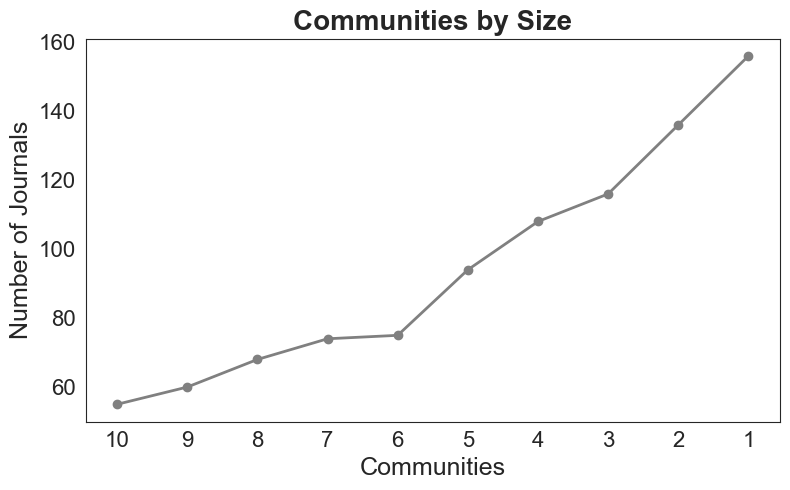

   community    n  x_axis
9         10   55       0
8          9   60       1
7          8   68       2
6          7   74       3
5          6   75       4
4          5   94       5
3          4  108       6
2          3  116       7
1          2  136       8
0          1  156       9


In [24]:
# Convertir nodos a DataFrame
nodes_df = pd.DataFrame.from_dict(dict(journal_citation_graph_weighted_tbl_small.nodes(data=True)), orient='index')
nodes_df['node'] = nodes_df.index
nodes_df.reset_index(drop=True, inplace=True)

nodes_df['community'] = nodes_df['community'].astype(int)

# Contar comunidades y seleccionar las 10 más grandes
community_counts = nodes_df['community'].value_counts().reset_index()
community_counts.columns = ['community', 'n']
community_counts = community_counts.sort_values('n', ascending=False).head(10)  # Tomar las 10 más grandes

# Ordenar de menor a mayor para la visualización
community_counts = community_counts.sort_values('n', ascending=True)

# Agregar un nuevo índice consecutivo
community_counts['x_axis'] = range(len(community_counts))

sns.set_style("white")
sns.despine()  # Elimina bordes superiores y derechos

plt.figure(figsize=(8, 5))

# Gráfico de línea con puntos
plt.plot(
    community_counts['x_axis'],
    community_counts['n'],
    marker='o',
    linestyle='-',
    color='gray',
    linewidth=2,
    markersize=6
)

# Personalizar estilo
plt.title("Communities by Size", fontsize=20, weight='bold')
plt.xlabel("Communities", fontsize=18)
plt.ylabel("Number of Journals", fontsize=18)

# Configurar etiquetas del eje x para mostrar los números de comunidad originales
plt.xticks(community_counts['x_axis'], community_counts['community'], fontsize=16)
plt.yticks(fontsize=16)

# Estilo adicional
plt.grid(False)
plt.tight_layout()

# Guardar como SVG (opcional)
plt.savefig('./figura_tres/figura_3b.svg', format='svg')

plt.show()

# Mostrar la tabla de comunidades para referencia
print(community_counts)


### Figure 3c Longitudinal      

In [25]:
def analyze_figure_3c(journal_df, year_start, year_end):
    # Prepare edge data
    edges_df = journal_df[journal_df['JI_main'] != journal_df['JI_ref']][['JI_main', 'JI_ref', 'PY_ref']]
    edges_df.columns = ['from', 'to', 'year']

    # Figure 3C Edges Analysis
    figure_3c_edges = (edges_df['year']
                       .value_counts()
                       .reset_index()
                       .rename(columns={'index': 'year', 'count': 'n'})
                       .query(f'year >= {start_year} and year <= {year_end}')
                       .assign(percentage=lambda x: x['n'] / x['n'].max())
                       [['year', 'percentage']]
                       .sort_values('year'))

    # Figure 3C Nodes Analysis
    # Combine unique CO (Country/Organization) from both from and to columns
    nodes_years = pd.concat([
        edges_df[['from', 'year']].rename(columns={'from': 'CO'}),
        edges_df[['to', 'year']].rename(columns={'to': 'CO'})
    ]).drop_duplicates()

    # Group by CO and get the earliest year for each
    figure_3c_nodes = (nodes_years
                       .groupby('CO')['year']
                       .min()
                       .reset_index()['year']
                       .value_counts()
                       .reset_index()
                       .rename(columns={'index': 'year', 'count': 'n'})
                       .query(f'year >= {start_year} and year <= {year_end}')
                       .assign(percentage=lambda x: x['n'] / x['n'].max())
                       [['year', 'percentage']]
                       .sort_values('year'))

    return {
        'edges': figure_3c_edges,
        'nodes': figure_3c_nodes
    }

figure_3c = analyze_figure_3c(journal_df, start_year, year_end)
figure_3c_nodes = figure_3c['nodes']
figure_3c_edges = figure_3c['edges']



In [27]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


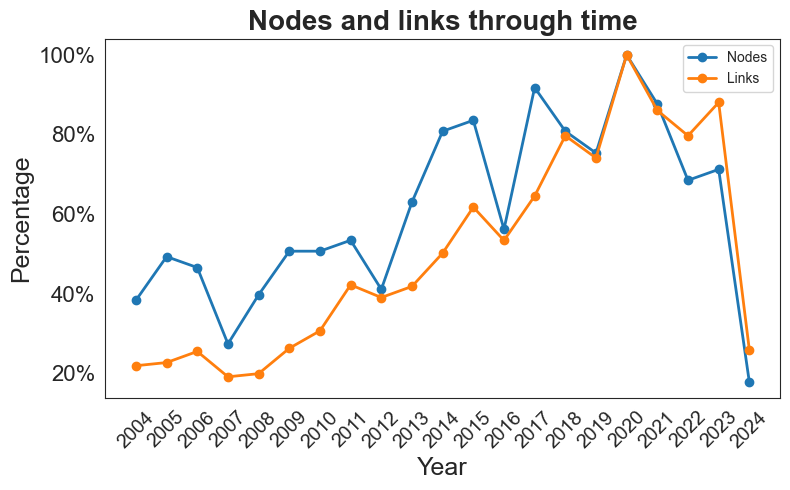

In [28]:
import plotly.graph_objs as go
figure_3c = pd.concat([
    figure_3c_nodes.assign(type='nodes'),
    figure_3c_edges.assign(type='links')
])

# Plotly interactive visualization
fig = go.Figure()

# Add traces for nodes and links
for type_name in ['nodes', 'links']:
    data = figure_3c[figure_3c['type'] == type_name]
    fig.add_trace(go.Scatter(
        x=data['year'],
        y=data['percentage'],
        mode='lines+markers',
        name=type_name.capitalize(),
        line=dict(width=3),
        marker=dict(size=10)
    ))

# Customize layout
fig.update_layout(
    title={
        'text': "Nodes and links through time",
        'font': {'size': 20, 'family': 'Times New Roman', 'color': 'black'}
    },
    xaxis=dict(
        title='Year',
        tickmode='linear',
        tick0=start_year,
        dtick=1,
        tickfont=dict(size=15, color='black'),
        title_font=dict(size=18)
    ),
    yaxis=dict(
        title='Percentage',
        tickformat=',.0%',
        tickfont=dict(size=15, color='black'),
        title_font=dict(size=18)
    ),
    legend=dict(
        font=dict(size=15),
        title=dict(text='', font=dict(size=1))  # Empty title with minimal font size
    ),
    plot_bgcolor='white',
    font=dict(family='Arial', color='black', size=20)
)

# Matplotlib SVG export
plt.figure(figsize=(8, 5))
for type_name in ['nodes', 'links']:
    data = figure_3c[figure_3c['type'] == type_name]
    plt.plot(data['year'], data['percentage'],
             marker='o',
             label=type_name.capitalize(),
             linewidth=2)




plt.title("Nodes and links through time", fontsize=20, weight='bold')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.xticks(range(start_year, year_end+1), rotation=45, fontsize=14)
plt.yticks(fontsize=16)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend()
plt.tight_layout()
plt.savefig('./figura_tres/figura_3.svg')


## 3.4 Author Analysis


In [29]:
def create_author_network(author_df, filter_components=True):
    # Crear el grafo
    G = nx.from_pandas_edgelist(author_df, source='from', target='to', edge_attr="PY")

    if filter_components:
        # Obtener componentes conexas
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    # Calcular grado de centralidad
    degree_dict = dict(G.degree())
    nx.set_node_attributes(G, degree_dict, "degree")

    # Calcular comunidades usando Louvain
    communities = community_louvain.best_partition(G,random_state=42)
    community_sizes = {}
    for node, comm in communities.items():
        community_sizes[comm] = community_sizes.get(comm, 0) + 1

    sorted_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)

    community_mapping = {old_comm: new_index+1 for new_index, old_comm in enumerate(sorted_communities)}
    updated_communities = {node: community_mapping[comm] for node, comm in communities.items()}
    nx.set_node_attributes(G, updated_communities, "community")

    return G

def create_weighted_author_network(author_df):
    # Contar el número de conexiones y crear un nuevo DataFrame
    edge_weights = author_df.groupby(['from', 'to']).size().reset_index(name='Weight')

    # Crear el grafo con pesos en las aristas
    G = nx.from_pandas_edgelist(edge_weights, source='from', target='to', edge_attr='Weight')
    #G = nx.from_pandas_edgelist(edge_weights, source='from', target='to', edge_attr='weight', create_using=nx.Graph())
    # Calcular grado de centralidad
    degree_dict = dict(G.degree())
    nx.set_node_attributes(G, degree_dict, "degree")

    communities = community_louvain.best_partition(G)

    community_sizes = {}
    for node, comm in communities.items():
        community_sizes[comm] = community_sizes.get(comm, 0) + 1

    sorted_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)

    community_mapping = {old_comm: new_index+1 for new_index, old_comm in enumerate(sorted_communities)}

    updated_communities = {node: community_mapping[comm] for node, comm in communities.items()}
    nx.set_node_attributes(G, updated_communities, "community")



    return G

author_network_time = create_author_network(author_df)
author_network = create_weighted_author_network(author_df)


In [30]:
from networkx.algorithms import community

G = nx.from_pandas_edgelist(author_df, source='from', target='to', edge_attr='PY')
# Obtener los componentes conexos y filtrar el más grande
largest_cc = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc).copy()


# Agregar el primer año de colaboración de cada autor como nodo
PY = author_df.groupby('from')['PY'].min().to_dict()
nx.set_node_attributes(G_sub, PY, 'PY')

# Calcular grado de centralidad
degree_dict = dict(G_sub.degree())

# Detectar comunidades con Louvain
partition = community_louvain.best_partition(G_sub)

# Crear un DataFrame con los nodos y sus atributos
author_network_time = pd.DataFrame({
    'author': list(G_sub.nodes()),
    'degree': [degree_dict[node] for node in G_sub.nodes()],
    'community': [partition[node] for node in G_sub.nodes()],
    'PY': [G_sub.nodes[node].get('PY', None) for node in G_sub.nodes()]
})



<Figure size 640x480 with 0 Axes>

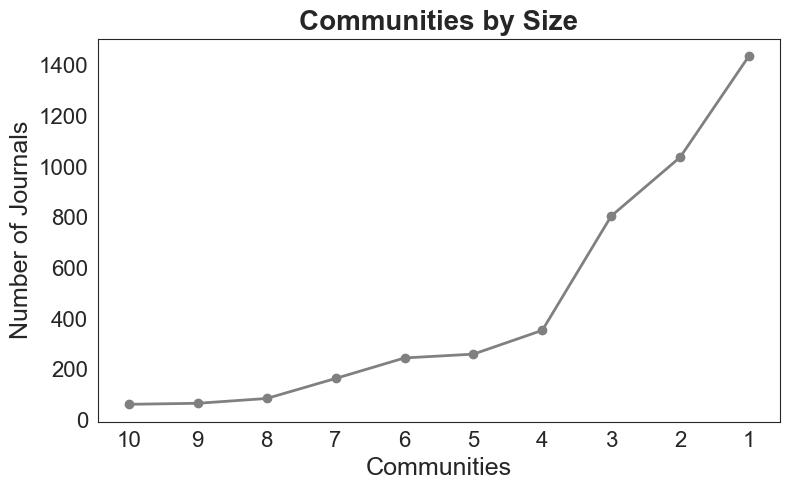

In [31]:
nodes_df = pd.DataFrame.from_dict(dict(author_network.nodes(data=True)), orient='index')
nodes_df['node'] = nodes_df.index
nodes_df.reset_index(drop=True, inplace=True)

nodes_df['community'] = nodes_df['community'].astype(int)

# Contar comunidades y seleccionar las 10 más grandes
community_counts = nodes_df['community'].value_counts().reset_index()
community_counts.columns = ['community', 'n']
community_counts = community_counts.sort_values('n', ascending=False).head(10)  # Tomar las 10 más grandes

# Ordenar de menor a mayor para la visualización
community_counts = community_counts.sort_values('n', ascending=True)

# Agregar un nuevo índice consecutivo
community_counts['x_axis'] = range(len(community_counts))

sns.set_style("white")
sns.despine()  # Elimina bordes superiores y derechos

plt.figure(figsize=(8, 5))

# Gráfico de línea con puntos
plt.plot(
    community_counts['x_axis'],
    community_counts['n'],
    marker='o',
    linestyle='-',
    color='gray',
    linewidth=2,
    markersize=6
)
# Personalizar estilo
plt.title("Communities by Size", fontsize=20, weight='bold')
plt.xlabel("Communities", fontsize=18)
plt.ylabel("Number of Journals", fontsize=18)

# Etiquetas del eje x
plt.xticks(community_counts['x_axis'], community_counts['community'], fontsize=16)
plt.yticks(fontsize=16)
# Estilo adicional
plt.grid(False)
plt.tight_layout()

# Guardar como SVG (opcional)
plt.savefig('./figura_cuatro/figura_4a.svg', format='svg')

plt.show()


### Figure 4b Longitudinal

In [32]:
fig_1c_edges = (author_df
    .pipe(lambda df: df[['PY']])  # Select year column
    .groupby('PY')
    .size()
    .reset_index(name='n')
    .query('PY >= @start_year and PY <= @year_end')
    .assign(percentage=lambda x: x['n'] / x['n'].max())
    [['PY', 'percentage']]
    .rename(columns={'PY': 'year'})
)


edges_df = author_df.copy()
fig_1c_nodes = (pd.concat([
    edges_df.rename(columns={'from': 'author', 'PY': 'year'})[['author', 'year']],
    edges_df.rename(columns={'to': 'author', 'PY': 'year'})[['author', 'year']]
])
    .drop_duplicates()
    .sort_values('year')
    .groupby('author')
    .first()
    .reset_index()
    .groupby('year')
    .size()
    .reset_index(name='n')
    .query('year >= @start_year and year <= @year_end')
    .assign(percentage=lambda x: x['n'] / x['n'].max())
    [['year', 'percentage']]
)



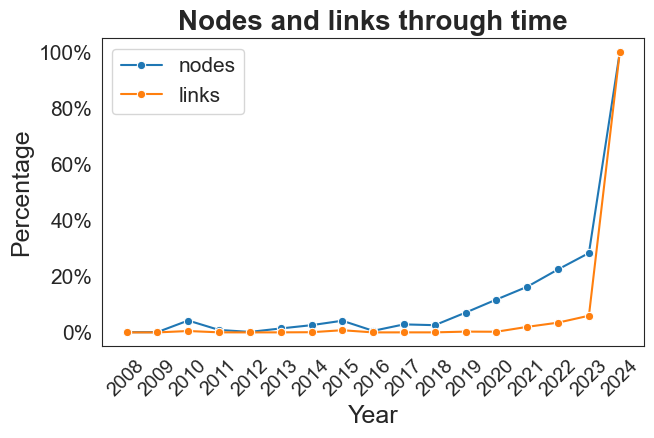

In [34]:
import matplotlib.ticker as mtick
fig_1c_nodes["type"] = "nodes"
fig_1c_edges["type"] = "links"

data = pd.concat([fig_1c_nodes, fig_1c_edges])

plt.figure(figsize=(7, 4))
sns.lineplot(data=data, x="year", y="percentage", hue="type", marker="o")



plt.xlabel("Year", fontsize=18)
plt.ylabel("Percentage", fontsize=18)
plt.title("Nodes and links through time", fontsize=20, weight='bold')
plt.xticks(np.arange(2008, year_end + 1, step=1), rotation=45, fontsize=14)
plt.yticks(fontsize=15)
plt.legend(title=None, fontsize=15, loc="upper left")



# Formatear el eje Y como porcentaje
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Si los valores están entre 0 y 1
plt.grid(False)
# Guardar la figura en formato SVG
plt.savefig("./figura_cuatro/figura_4b.svg", format="svg", bbox_inches="tight")
plt.show()

### Filtering only the top 10 nodes with best degree in the first 6 clusters.

In [35]:
def get_top_degree_nodes(graph, community_id, top_n=10):
    # Filtrar nodos por comunidad
    nodes_in_community = [n for n, d in graph.nodes(data=True) if d.get('community') == community_id]

    # Calcular grado de los nodos en la comunidad
    degree_dict = dict(graph.degree(nodes_in_community))

    # Ordenar nodos por grado de manera descendente y seleccionar los top_n
    top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:top_n]

    return top_nodes

# Obtener los 10 nodos con mayor grado en cada una de las primeras 6 comunidades
asn_TM_connected_1 = get_top_degree_nodes(author_network, 1)
asn_TM_connected_2 = get_top_degree_nodes(author_network, 2)
asn_TM_connected_3 = get_top_degree_nodes(author_network, 3)
asn_TM_connected_4 = get_top_degree_nodes(author_network, 4)
asn_TM_connected_5 = get_top_degree_nodes(author_network, 5)
asn_TM_connected_6 = get_top_degree_nodes(author_network, 6)




### Saving the nodes we're gonna show

In [36]:
# Guardar los nodos seleccionados en DataFrames
nodes_community_1 = pd.DataFrame({'name': asn_TM_connected_1})
nodes_community_2 = pd.DataFrame({'name': asn_TM_connected_2})
nodes_community_3 = pd.DataFrame({'name': asn_TM_connected_3})
# nodes_community_4 = pd.DataFrame({'name': asn_TM_connected_4})
# nodes_community_5 = pd.DataFrame({'name': asn_TM_connected_5})
# nodes_community_6 = pd.DataFrame({'name': asn_TM_connected_6})

# Unir los nodos seleccionados
nodes_selected_10 = pd.concat([nodes_community_1, nodes_community_2, nodes_community_3])



In [37]:
# Filtrar los nodos seleccionados en el grafo
graph_nodes = list(author_network.nodes())
asn_selected_nodes = author_network.subgraph(nodes_selected_10['name'].tolist()).copy()

# Calcular el grado de los nodos seleccionados
for node in asn_selected_nodes.nodes():
    asn_selected_nodes.nodes[node]['degree'] = author_network.degree(node)

for u, v, d in asn_selected_nodes.edges(data=True):
    d['weight'] = d.get('weight', 1)

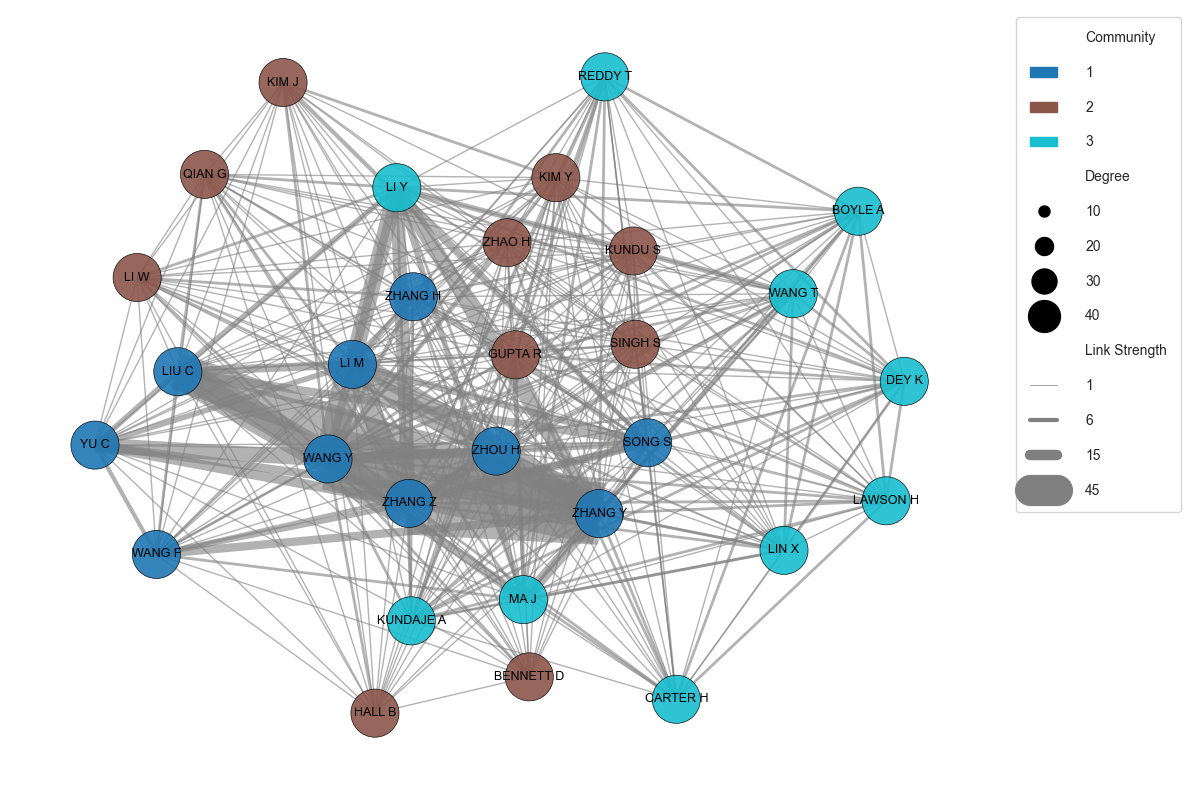

In [38]:

G = asn_selected_nodes
G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.spring_layout(G)

node_communities = nx.get_node_attributes(G, "community")
node_degrees = dict(G.degree())

def map_degree_to_size(d):
    """Mapea grados a tamaños de nodo. Ajusta los umbrales y valores a tus datos."""
    if d < 5:
        return 300
    elif d < 10:
        return 600
    elif d < 15:
        return 900
    else:
        return 1200


node_sizes = []

for n in G.nodes():
    d_value = node_degrees.get(n, 0)
    node_sizes.append(map_degree_to_size(d_value))

edge_widths = []
for (u,v) in G.edges():
    w = G[u][v].get("Weight")
    edge_widths.append(w)

# for u, v, data in G.edges(data=True):
#     data["weight"] = data.pop("Weight")



communities_set = sorted(set(nx.get_node_attributes(G, 'community').values()))
color_map = plt.get_cmap('tab10', len(communities_set))
node_colors = {n: color_map(communities_set.index(G.nodes[n]['community'])) for n in G.nodes}

for node, color in node_colors.items():
    r, g, b, a = [int(color[i] * 255) for i in range(3)] + [color[3]]  # a ya está en 0-1

    G.nodes[node]['viz'] = {
        "color": {"r": r, "g": g, "b": b, "a": a}  # a ya está en el rango correcto
    }

node_colors = [color_map(communities_set.index(G.nodes[n]['community'])) for n in G.nodes]


# 7. Dibujar los nodos, aristas y etiquetas
plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.9,
    linewidths=0.5,
    edgecolors="black"
)
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.6,
    edge_color="gray"
)
nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    font_color="black"
)

community_legend = [
    Patch(color=color_map(communities_set.index(c)), label=f"{c}")
    for c in communities_set
]

# Leyenda de grados (solo intervalo)
degree_legend = [
    Line2D([0], [0], marker='o', color='w', label='10',
           markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='20',
           markerfacecolor='black', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='30',
           markerfacecolor='black', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='40',
           markerfacecolor='black', markersize=25)
]

unique_weights = sorted(set(int(w) for _,_,w in G.edges(data="Weight") if w is not None))

if len(unique_weights) >= 4:
    selected_weights = [
        unique_weights[0],
        unique_weights[len(unique_weights)//3],
        unique_weights[2*len(unique_weights)//3],
        unique_weights[-1]
    ]
else:
    selected_weights = unique_weights

def map_weight_to_width(w):
    return w * 0.5

# 4. Crear la leyenda con pesos reales
linkstrength_legend = [
    Line2D([0], [0], color='gray', lw=map_weight_to_width(w), label=f"{int(w)}")
    for w in selected_weights
]

title_community = Line2D([], [], color='none', label="Community")
title_degree = Line2D([], [], color='none', label="Degree")
title_linkstrength = Line2D([], [], color='none', label="Link Strength")

community_legend = [title_community] + community_legend
degree_legend = [title_degree] + degree_legend
linkstrength_legend = [title_linkstrength] + linkstrength_legend

# Mostrar la leyenda con títulos
plt.legend(
    handles=(community_legend + degree_legend + linkstrength_legend),
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    labelspacing=1.5,      # Espacio vertical entre líneas
    handletextpad=2,       # Espacio entre el marcador y el texto
    borderpad=1            # Espacio del borde de la leyenda con su contenido
)


plt.axis("off")
plt.tight_layout()
plt.savefig('./figura_cuatro/figura_4c.svg', format='svg')
plt.show()

# Exportar el grafo a formato GEXF con los atributos 'community' y 'color'
gexf_path = "figura_cuatro/autores_collaboration_graph_louvain.gexf"
nx.write_gexf(G, gexf_path)

# Tree of Science Graph


In [ ]:
# # import pandas as pd
# # import networkx as nx
# # import matplotlib.pyplot as plt

# file_path = "all_data_cacao_1.xlsx"
# nodes_df = pd.read_excel(file_path, sheet_name=17)
# edges_df = pd.read_excel(file_path, sheet_name=16)

# # Crear el grafo
# G = nx.from_pandas_edgelist(
#     edges_df,
#     source="Source",
#     target="Target",
#     create_using=nx.Graph()
# )

# # Agregar atributos de nodos
# node_attrs = nodes_df.set_index("id").to_dict("index")
# nx.set_node_attributes(G, node_attrs)

# # Grado de los nodos (número de citaciones)
# degree_dict = dict(G.degree())

# # Escalar tamaño de nodos basado en número de citaciones
# node_sizes = [degree_dict[node]*10 for node in G.nodes()]  # Puedes ajustar el *10 según el rango que quieras

# # Número de nodos y aristas
# num_nodos = G.number_of_nodes()
# num_aristas = G.number_of_edges()

# # Estadísticas
# max_cit = max(degree_dict.values())
# prom_cit = sum(degree_dict.values()) / len(degree_dict)

# # Distribución por subfield
# subfields = nx.get_node_attributes(G, "subfield")
# subfield_series = pd.Series(subfields).value_counts(normalize=True) * 100

# # Visualización
# # plt.figure(figsize=(10, 8))
# # pos = nx.spring_layout(G, k=0.5, iterations=50)

# # nx.draw_networkx_nodes(G, pos, node_size=node_sizes)
# # nx.draw_networkx_edges(G, pos, alpha=0.3)
# # nx.draw_networkx_labels(G, pos, font_size=7)

# # Leyenda textual (informativa)
# leyenda = (
#     f"Nodes (papers): {num_nodos}\n"
#     f"Links: {num_aristas}\n"
# )
# for subfield, pct in subfield_series.items():
#     leyenda += f" - Sub-topic {subfield}: {pct:.1f}%\n"

# plt.gcf().text(0.02, 0.5, leyenda, fontsize=9, va='center', bbox=dict(facecolor='white', alpha=0.7))

# # Leyenda visual de número de citaciones (círculos de ejemplo)
# from matplotlib.lines import Line2D

# legend_sizes = [10, 25, 40]  # Mapeo de ejemplo para subfields 1, 2, 3
# legend_labels = [" ", " ", " "]  # O puedes poner rangos numéricos si prefieres

# legend_elements = [
#     plt.scatter([], [], s=size**2 * 0.05, color="black", label=label)
#     for size, label in zip(legend_sizes, legend_labels)
# ]

# plt.legend(
#     handles=legend_elements,
#     title="Number of citations",
#     loc='upper right',
#     fontsize=9,
#     title_fontsize=10,
#     frameon=True
# )

# plt.axis("off")
# plt.savefig("red_citaciones.svg", format="svg", bbox_inches="tight")
# plt.show()

